# **CSE564: *Reinforcement Learning Assignment-1***

In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from utils import Policy, Plot, epsilon_greedy, UCB, epsiode, parallel_episodes, parallel_gradient_episodes

plt.style.use("seaborn-v0_8-darkgrid")
warnings.filterwarnings("ignore")

## **Utility Functions**

In [2]:
def plot_rewards(rewards: np.ndarray, T: int, verbose: bool|None = False, show: bool|None = True, **kwargs) -> None:
    """
    generates a plot of the rewards received at each time step
    :param rewards: the rewards received at each time step
    """

    plt.figure(figsize=(13, 4))

    plt.axhline(y=0, color="black")
    plt.axvline(x=0, color="black")
    plt.plot(rewards, linewidth=0.8, label=kwargs["label"])
    plt.axhline(y=np.mean(rewards), color="red", linestyle="--", label="Average reward")

    if verbose:
        print(f"Average reward: {np.mean(rewards)}")

    dy = 0.5
    plt.xticks(np.arange(0, T+1, 100))
    plt.yticks(np.arange(np.round(np.min(rewards)*2)/2, np.round(np.max(rewards)*2)/2 + dy, dy))
    plt.xlabel("Time step t")
    plt.ylabel("Reward R_t")

    plt.title("Rewards received at each time step")
    plt.legend()
    plt.grid(False)
    plt.grid(True, axis="y")
    if show: plt.show()


def plot_episodes(plots: list[Plot], ticks: tuple[np.ndarray], ylabel: str, title: str, show: bool|None = True) -> None:
    plt.figure(figsize=(13, 5))

    plt.axhline(y=0, color="black")
    plt.axvline(x=0, color="black")
    for values, plot in plots:
        plt.plot(values, linewidth=plot["linewidth"], alpha=plot["alpha"], color=plot["color"], label=plot["label"])

    plt.xticks(ticks[0])
    plt.yticks(ticks[1])
    plt.xlabel("Time step t")
    plt.ylabel(ylabel)

    plt.title(title)
    plt.legend()
    plt.grid(False)
    plt.grid(True, axis="y")
    if show: plt.show()

## **Question: 1**

For the following sequence, calculate the estimates of the expected reward for all arms using:

1. Sample Mean
2. Exponential (Recency) Weighted Average with $\alpha = 0.1$

Assume the  initial estimates as $5$, $8$, $-6$, and $0$ for arms $1$, $2$, $3$, and $4$ respectively. The following is the sequence of the selected actions $A_{t}$ and rewards $R_{t}$.

| $t$ | $1$ | $2$ | $3$ | $4$ | $5$ | $6$ | $7$ | $8$ | $9$ |
|:---:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
| $A_{t}$ | $2$ | $3$ | $4$ | $4$ | $1$ | $2$ | $3$ | $3$ | $1$ |
| $R_{t}$ | $-5$ | $9$ | $5$ | $2$ | $-4$ | $9$ | $10$ | $2$ | $1$ |

### **Solution**

In [3]:
actions = np.array([2, 3, 4, 4, 1, 2, 3, 3, 1])
rewards = np.array([-5, 9, 5, 2, -4, 9, 10, 2, 1])

#### **1. Sample Mean**

The expected reward for an arm $a \in \mathcal{A}$ using the sample mean is estimated as follows

$$\begin{align*}
    Q_{t}(a) = \frac{\text{Sum of rewards given by } a}{\text{\# of times } a \text{ was selected}} 
    = \frac{\sum_{i=1}^{t-1} \mathbb{I}_{\{A_{t}=a\}} \cdot R_{i}}{\sum_{i=1}^{t-1} \mathbb{I}_{\{A_{t}=a\}}}
\end{align*}$$

Moreover, the initial estimates $Q_{0}(a) \ \forall \ a \in \mathcal{A}$ are not counted in the above equation. Therefore, the expected reward for all arms using the sample mean is estimated as follows

|  | $Q_{t}(1)$ | $Q_{t}(2)$ | $Q_{t}(3)$ | $Q_{t}(4)$ |
|:-----:|:-----:|:-----:|:-----:|:-----:|
| $t=0$ | $5$ | $8$ | $-6$ | $0$ |
| $t=1$ | $5$ | $Q_{1}(2) = -5$ | $-6$ | $0$ |
| $t=2$ | $5$ | $-5$ | $Q_{2}(3) = 9$ | $0$ |
| $t=3$ | $5$ | $-5$ | $9$ | $Q_{3}(4) = 5$ |
| $t=4$ | $5$ | $-5$ | $9$ | $Q_{4}(4) = \frac{5+2}{2} = 3.5$ |
| $t=5$ | $Q_{5}(1) = -4$ | $-5$ | $9$ | $3.5$ |
| $t=6$ | $-4$ | $Q_{6}(2) = \frac{-5+9}{2} = 2$ | $9$ | $3.5$ |
| $t=7$ | $-4$ | $2$ | $Q_{7}(3) = \frac{9+10}{2} = 9.5$ | $3.5$ |
| $t=8$ | $-4$ | $2$ | $Q_{8}(3) = \frac{9+10+2}{3} = 7$ | $3.5$ |
| $t=9$ | $Q_{9}(1) = \frac{-4+1}{2} = -1.5$ | $2$ | $7$ | $3.5$ |

This also enforces that the estimates using sample mean are independent of the initial estimates $Q_{0}(a) \ \forall \ a \in \mathcal{A}$. This is because as soon as an arm is selected for the first time, the initial estimate is replaced by the sample mean. More formally, the sample mean is used as follows

$$\begin{align*}
    Q^{(n)}(a) = \begin{cases}
        \frac{\sum_{i=1}^{n} R^{(i)}(a)}{n} & \text{if } n \geq 1 \\
        Q_{0}(a) & \text{if } n = 0
    \end{cases}
\end{align*}$$

Where $Q^{(j)}(a)$ is the estimate of and $R^{(j)}(a)$ is the reward given by arm $a$ when it was selected for the $j^{th}$ time.

A verification of the above solution coded in Python is given below.

In [4]:
estimates = np.array([5, 8, -6, 0], dtype=np.float32)
counts = np.zeros(4)

print("t = 0:", estimates)
for t in range(9):
    counts[actions[t] - 1] += 1
    estimates[actions[t] - 1] += (1 / counts[actions[t] - 1]) * (rewards[t] - estimates[actions[t] - 1])
    print(f"t = {t+1}:", estimates)

t = 0: [ 5.  8. -6.  0.]
t = 1: [ 5. -5. -6.  0.]
t = 2: [ 5. -5.  9.  0.]
t = 3: [ 5. -5.  9.  5.]
t = 4: [ 5.  -5.   9.   3.5]
t = 5: [-4.  -5.   9.   3.5]
t = 6: [-4.   2.   9.   3.5]
t = 7: [-4.   2.   9.5  3.5]
t = 8: [-4.   2.   7.   3.5]
t = 9: [-1.5  2.   7.   3.5]


#### **2. Exponential Weighted Average ($\alpha = 0.1$)**

The expected reward for an arm $a \in \mathcal{A}$ using the exponential weighted average is (incrementally) estimated as follows

$$\begin{align*}
    Q^{(n)}(a) &= \alpha \cdot R^{(n)}(a) + (1-\alpha) \cdot Q^{(n-1)}(a) \\
    &= Q^{(n-1)}(a) + \alpha \cdot (R^{(n)}(a) - Q^{(n-1)}(a))
\end{align*}$$

Where $Q^{(j)}(a)$ is the estimate of and $R^{(j)}(a)$ is the reward given by arm $a$ when it was selected for the $j^{th}$ time. Therefore, the expected reward for all arms using the sample mean is estimated as follows

|  | $Q_{t}(1)$ | $Q_{t}(2)$ | $Q_{t}(3)$ | $Q_{t}(4)$ |
|:-----:|:-----:|:-----:|:-----:|:-----:|
| $t=0$ | $5$ | $8$ | $-6$ | $0$ |
| $t=1$ | $5$ | $Q_{1}(2) = 8 + 0.1 \cdot (-5 - 8) = 6.7$ | $-6$ | $0$ |
| $t=2$ | $5$ | $6.7$ | $Q_{2}(3) = -6 + 0.1 \cdot (9 - (-6)) = -4.5$ | $0$ |
| $t=3$ | $5$ | $6.7$ | $-4.5$ | $Q_{3}(4) = 0 + 0.1 \cdot (5 - 0) = 0.5$ |
| $t=4$ | $5$ | $6.7$ | $-4.5$ | $Q_{4}(4) = 0.5 + 0.1 \cdot (2 - 0.5) = 0.65$ |
| $t=5$ | $Q_{5}(1) = 5 + 0.1 \cdot (-4 - 5) = 4.1$ | $6.7$ | $-4.5$ | $0.65$ |
| $t=6$ | $4.1$ | $Q_{6}(2) = 6.7 + 0.1 \cdot (9 - 6.7) = 6.93$ | $-4.5$ | $0.65$ |
| $t=7$ | $4.1$ | $6.93$ | $Q_{7}(3) = -4.5 + 0.1 \cdot (10 - (-4.5)) = -3.05$ | $0.65$ |
| $t=8$ | $4.1$ | $6.93$ | $Q_{8}(3) = -3.05 + 0.1 \cdot (2 - (-3.05)) = -2.545$ | $0.65$ |
| $t=9$ | $Q_{9}(1) = 4.1 + 0.1 \cdot (2 - 4.1) = 3.79$ | $6.93$ | $-2.545$ | $0.65$ |

This also enforces that the estimates using exponential weighted mean are dependent on the initial estimates $Q_{0}(a) \ \forall \ a \in \mathcal{A}$. This is because the initial values are also used to incrementally update future estimates of the arms. More formally, the following dependency is observed for the exponential weighted mean

$$\begin{align*}
    Q^{(n)}(a) &= \alpha \cdot R_{n} + (1-\alpha) \cdot Q^{(n-1)}(a) \\
    &= \alpha \cdot R_{n} + (1-\alpha) \left( \alpha \cdot R_{n-1} + (1-\alpha) \cdot Q^{(n-2)}(a) \right) \\
    &= \alpha \cdot R_{n} + \alpha (1-\alpha) \cdot R_{n-1} + (1-\alpha)^{2} \cdot Q^{(n-2)}(a) \\
    &= \alpha \cdot R_{n} + \alpha (1-\alpha) \cdot R_{n-1} + \alpha (1-\alpha)^{2} \cdot R_{n-2} + (1-\alpha)^{3} \cdot Q^{(n-3)}(a) \\
    &= (1-\alpha)^{n} \cdot Q_{0}(a) + \sum_{i=1}^{n} \alpha (1-\alpha)^{n-i} \cdot R_{i}
\end{align*}$$

The pattern is easy to notice, and trivial when $Q_{0}(a)$ is assumed to be $R_{0}$ for each arm $a \in \mathcal{A}$.

A verification of the above solution coded in Python is given below.

In [5]:
alpha: float = 0.1
estimates = np.array([5, 8, -6, 0], dtype=np.float32)
counts = np.zeros(4)

print("t = 0:", estimates)
for t in range(9):
    counts[actions[t] - 1] += 1
    estimates[actions[t] - 1] += alpha * (rewards[t] - estimates[actions[t] - 1])
    print(f"t = {t+1}:", estimates)

t = 0: [ 5.  8. -6.  0.]
t = 1: [ 5.   6.7 -6.   0. ]
t = 2: [ 5.   6.7 -4.5  0. ]
t = 3: [ 5.   6.7 -4.5  0.5]
t = 4: [ 5.    6.7  -4.5   0.65]
t = 5: [ 4.1   6.7  -4.5   0.65]
t = 6: [ 4.1   6.93 -4.5   0.65]
t = 7: [ 4.1   6.93 -3.05  0.65]
t = 8: [ 4.1    6.93  -2.545  0.65 ]
t = 9: [ 3.79   6.93  -2.545  0.65 ]


## **Question: 2**

Using $\epsilon$-greedy, generate an episode of $T = 1000$ time steps.

Consider the action space $\mathcal{A} = \{ 1, 2, 3, 4 \}$.
The distribution of rewards associated with each arm are as follows:

| Arm | $1$ | $2$ | $3$ | $4$ |
|:---:|:-:|:-:|:-:|:-:|
| $R_{t}$ | $N[0, 1]$ | $N[0, 0.7]$ | $N[0, 0.2]$ | $N[0.2, 0.5]$ |

Use the sample mean as the estimate of $\epsilon$-greedy selection, for

1. $\epsilon = 0.2$
2. $\epsilon = 0.8$
3. $\epsilon = 0$
4. $\epsilon = 1$
5. Take $\epsilon$ to be a function of time step $t$, such that it decreases as $t$ increases.

Plot the rewards that you get at every time step in all 5 cases.
What is the average reward for each $\epsilon$?

### **Solution**

The solution is a simple implementation of the $\epsilon$-greedy algorithm in Python. For part 5:

$$\begin{align*}
\epsilon &= f(t); \quad \frac{df(t)}{dt} \leq 0 \quad \forall \ t \in \mathbb{N} \\
\text{so, let } f(t) &= e^{-\frac{t}{5}}
\end{align*}$$

In [6]:
T: int = 1000
arms = np.array([[0, 1], [0, 0.7], [0, 0.2], [0.2, 0.5]])

Average reward: 0.14833128304188337


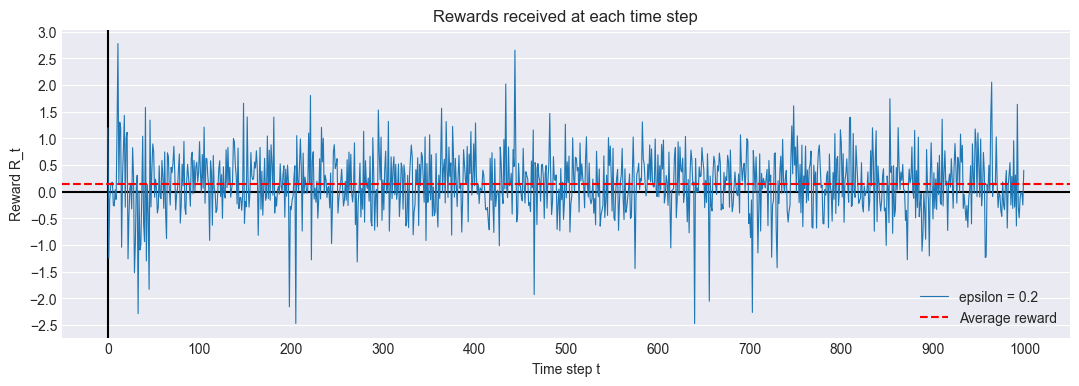

In [7]:
policy: Policy = lambda estimates, **_: epsilon_greedy(estimates, eps=0.2)

rewards, _, _ = epsiode(T, arms, policy)
plot_rewards(rewards, T, verbose=True, label="epsilon = 0.2")

Average reward: 0.03755897315230661


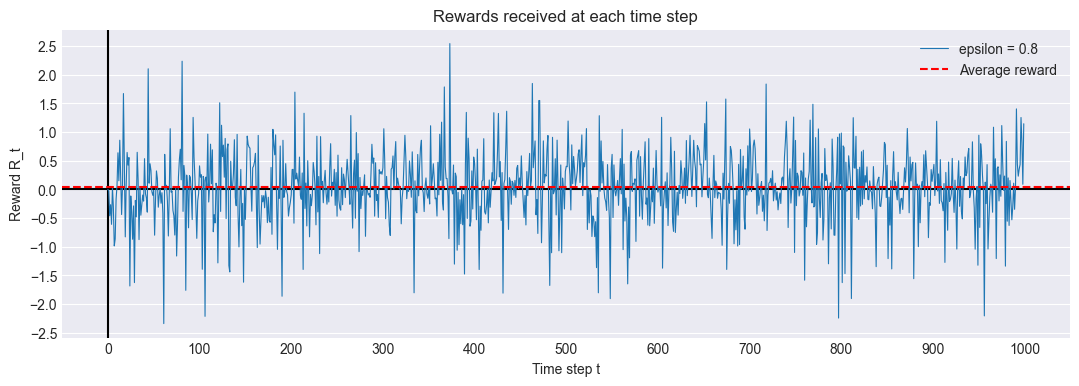

In [8]:
policy: Policy = lambda estimates, **_: epsilon_greedy(estimates, eps=0.8)

rewards, _, _ = epsiode(T, arms, policy)
plot_rewards(rewards, T, verbose=True, label="epsilon = 0.8")

Average reward: 0.206592156176625


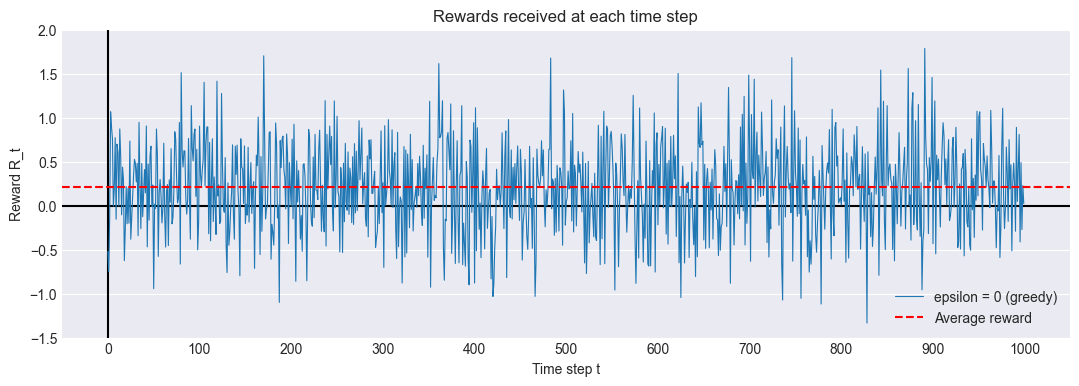

In [9]:
policy: Policy = lambda estimates, **_: epsilon_greedy(estimates, eps=0.0)

rewards, _, _ = epsiode(T, arms, policy)
plot_rewards(rewards, T, verbose=True, label="epsilon = 0 (greedy)")

Average reward: 0.045964583866156886


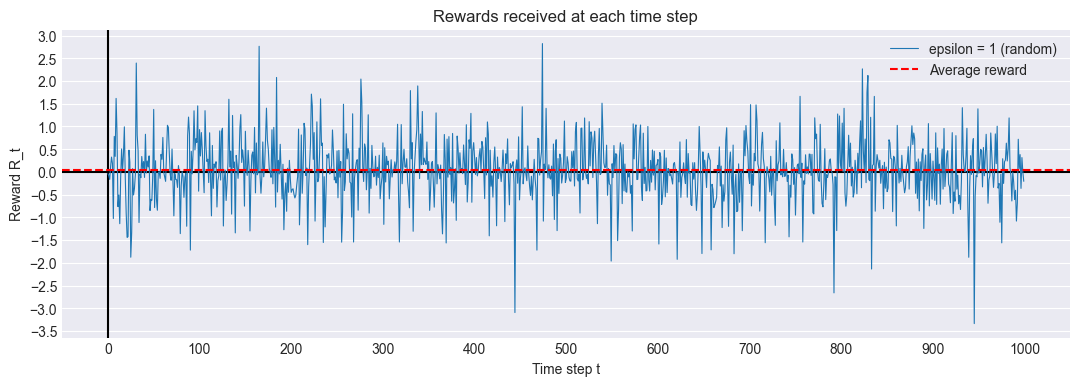

In [10]:
policy: Policy = lambda estimates, **_: epsilon_greedy(estimates, eps=1.0)

rewards, _, _ = epsiode(T, arms, policy)
plot_rewards(rewards, T, verbose=True, label="epsilon = 1 (random)")

Average reward: 0.22931748167173738


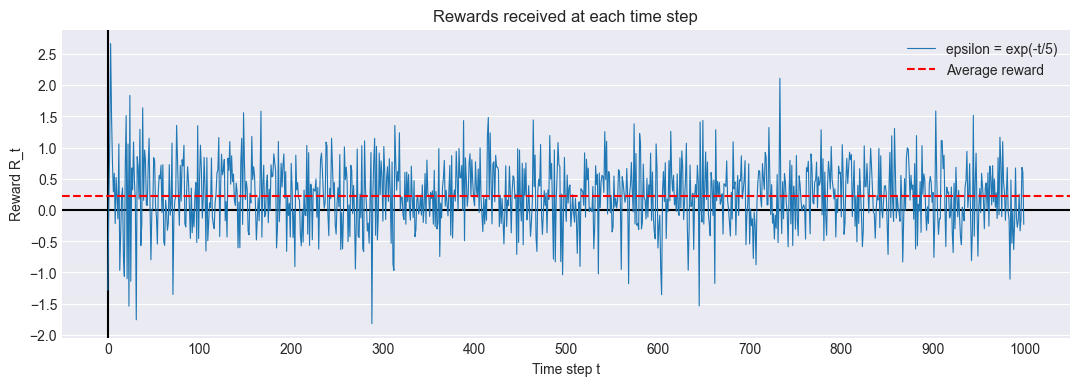

In [11]:
policy: Policy = lambda estimates, **kwargs: epsilon_greedy(estimates, np.exp(-kwargs["t"]/5))

rewards, _, _ = epsiode(T, arms, policy)
plot_rewards(rewards, T, verbose=True, label="epsilon = exp(-t/5)")

## **Question: 3**

Read Section 2.3 of *Introduction to Reinforcement Learning by Sutton and Barto* and generate both plots in Figure 2.2.

In [12]:
N: int = 2000
T: int = 1000
k: int = 10
std: float = 1.0

policies: list[Policy] = [
    lambda estimates, **_: epsilon_greedy(estimates, eps=0.0),
    lambda estimates, **_: epsilon_greedy(estimates, eps=0.01),
    lambda estimates, **_: epsilon_greedy(estimates, eps=0.1)
]

average_reward, optimal_action = parallel_episodes(N, T, k, policies, std)

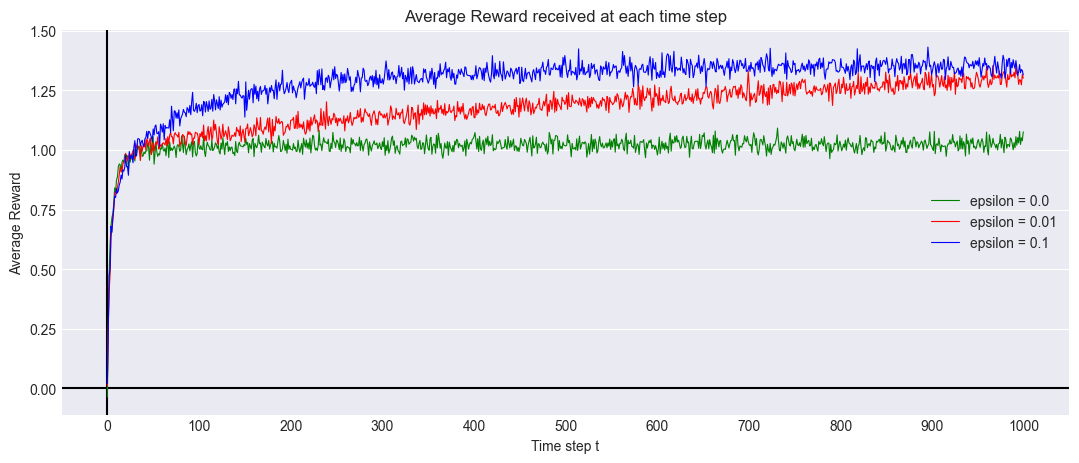

In [13]:
plots = [
    [average_reward[:, 0], dict(linewidth=0.8, alpha=1.0, color="green", label="epsilon = 0.0")],
    [average_reward[:, 1], dict(linewidth=0.8, alpha=1.0, color="red", label="epsilon = 0.01")],
    [average_reward[:, 2], dict(linewidth=0.8, alpha=1.0, color="blue", label="epsilon = 0.1")]
]

xticks = np.arange(0, T+1, 100)
yticks = np.arange(0, 1.65, 0.25)

plot_episodes(plots, (xticks, yticks), ylabel="Average Reward", title="Average Reward received at each time step")

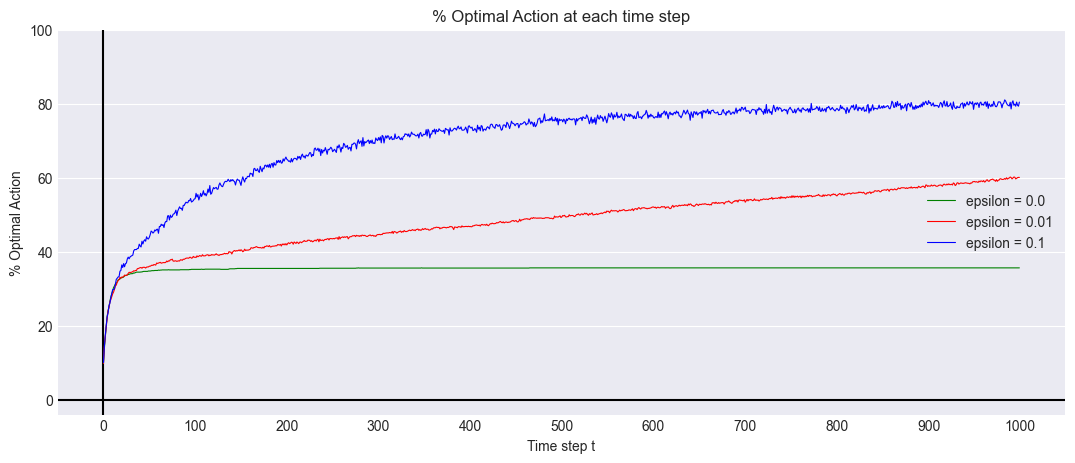

In [14]:
plots = [
    [optimal_action[:, 0], dict(linewidth=0.8, alpha=1.0, color="green", label="epsilon = 0.0")],
    [optimal_action[:, 1], dict(linewidth=0.8, alpha=1.0, color="red", label="epsilon = 0.01")],
    [optimal_action[:, 2], dict(linewidth=0.8, alpha=1.0, color="blue", label="epsilon = 0.1")]
]

xticks = np.arange(0, T+1, 100)
yticks = np.arange(0, 101, 20)

plot_episodes(plots, (xticks, yticks), ylabel=r"% Optimal Action", title=r"% Optimal Action at each time step")

## **Question: 4**

Repeat Question 3 by considering the variance of the reward distribution of each arm to be 4.

### **Solution**

It is given that the reward distribution of each arm has a variance $\sigma^{2} = 4$, i.e. the standard deviation is $\sigma = 2$. 
So we simply repeat the above experiment, setting the reward distribution of each arm to be $N[\mu_{a}, 4]$, where $\mu_{a}$ is drawn from the standard normal distribution $N[0, 1] \ \forall \ a \in \mathcal{A}$ for each episode.

In [15]:
N: int = 2000
T: int = 1000
k: int = 10
std: float = 2.0

policies: list[Policy] = [
    lambda estimates, **_: epsilon_greedy(estimates, eps=0.0),
    lambda estimates, **_: epsilon_greedy(estimates, eps=0.01),
    lambda estimates, **_: epsilon_greedy(estimates, eps=0.1)
]

average_reward, optimal_action = parallel_episodes(N, T, k, policies, std)

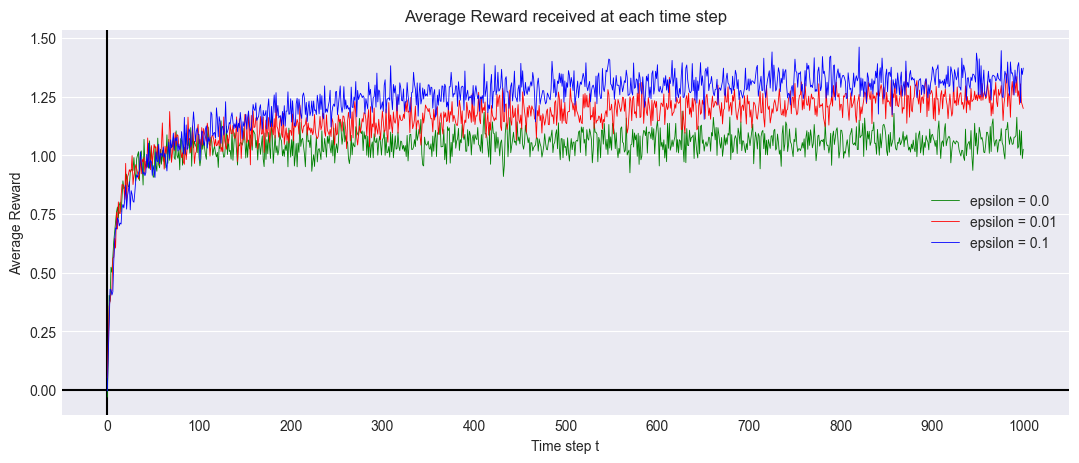

In [16]:
plots = [
    [average_reward[:, 0], dict(linewidth=0.6, alpha=1.0, color="green", label="epsilon = 0.0")],
    [average_reward[:, 1], dict(linewidth=0.6, alpha=1.0, color="red", label="epsilon = 0.01")],
    [average_reward[:, 2], dict(linewidth=0.6, alpha=1.0, color="blue", label="epsilon = 0.1")]
]

xticks = np.arange(0, T+1, 100)
yticks = np.arange(0, 1.65, 0.25)

plot_episodes(plots, (xticks, yticks), ylabel="Average Reward", title="Average Reward received at each time step")

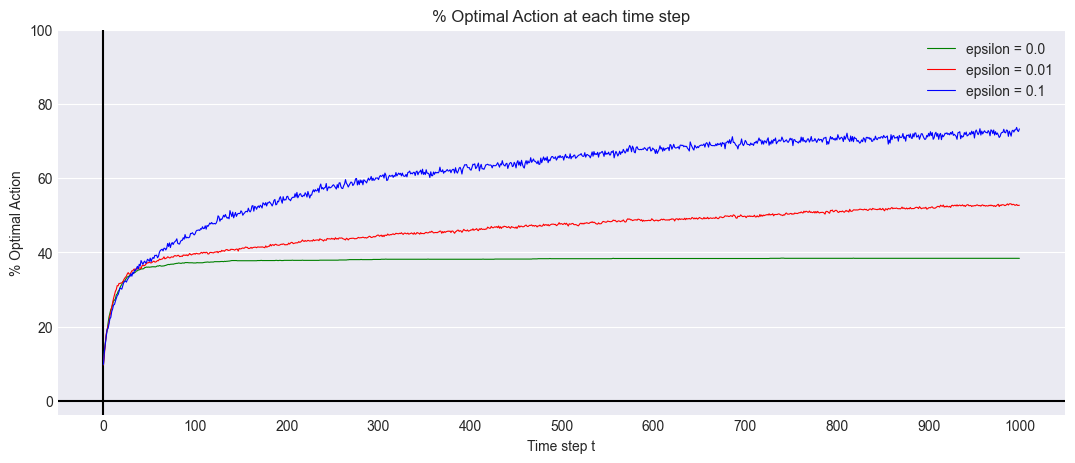

In [17]:
plots = [
    [optimal_action[:, 0], dict(linewidth=0.8, alpha=1.0, color="green", label="epsilon = 0.0")],
    [optimal_action[:, 1], dict(linewidth=0.8, alpha=1.0, color="red", label="epsilon = 0.01")],
    [optimal_action[:, 2], dict(linewidth=0.8, alpha=1.0, color="blue", label="epsilon = 0.1")]
]

xticks = np.arange(0, T+1, 100)
yticks = np.arange(0, 101, 20)

plot_episodes(plots, (xticks, yticks), ylabel=r"% Optimal Action", title=r"% Optimal Action at each time step")

## **Question: 5**

Read Section 2.7 of *Introduction to Reinforcement Learning by Sutton and Barto*. Generate Figure 2.4 and solve Exercise 2.8.

*Exercise 2.8: (UCB Spikes)* \
In Figure 2.4, the UCB algorithm shows a distinct spike in performance on the $11^{th}$ step. Why is this? Note that for your answer to be fully
satisfactory, it must explain both why the reward increases on the $11^{th}$ step and why it decreases on the subsequent steps. \
*Hint: If $c = 1$, then the spike is less prominent.*

### **Solution**

In the generated figure, the UCB algorithm shows a distinct spike in performance on the $11^{th}$ step. This is because the UCB algorithm initially tries to explore all arms based on the highest upper confidence bound. The upper confidence bound is a measure of the uncertainty in the estimate of the expected reward of an arm. It works by selecting the arm

$$\begin{equation*}
    A_{t} = \argmax_{a \in \mathcal{A}} \left[ \ Q_{t}(a) + c \sqrt \frac{\ln{t}}{N_{t}(a)} \ \right]
\end{equation*}$$

The UCB of the arm that has been selected relatively less increases. The UCB/uncertainty of an arm is inversely proportional to the number of times it has been selected. Hence, for the first $k = 10$ steps, the UCB algorithm selects each arm once, as $N_{t}(a) = 0 \  \forall \ a \in \mathcal{A}$.

Once each arm has been selected once, the UCB algorithm starts exploiting the *greedy* arm based on the noisy estimates, leading to a spike in performance. 
However, after the $11^{th}$ step, the uncertainty in other arms increases, and the current arm may not be the *greedy* arm anymore. Hence, the performance decreases as UCB tries to explore more to find the *best* arm.

The spike is less prominent in case $c = 1$ because $c \in \mathbb{R^{+}}$ is a parameter to control the degree of exploration. $c$ essentially weighs the upper confidence bound - measuring the importance that must be given to the upper confidence bound. Since UCB is directly proportional to $c$, decreasing it results in the algorithm getting stuck with a sub-optimal, and decreases the spike in performance. Moreover, the *more* greedy arm may not be selected as often.

In general, for any fixed $c$, it is common to observe a spike in the performance at the $(k+1)^{th}$ step for a $k$-armed bandit testbed.

In [18]:
N: int = 2000
T: int = 1000
k: int = 10
std: float = 1.0

policies: list[Policy] = [
    lambda estimates, **_: epsilon_greedy(estimates, eps=0.1),
    lambda estimates, t, counts: UCB(estimates, counts, t, c=2),
]

average_reward, _ = parallel_episodes(N, T, k, policies, std)

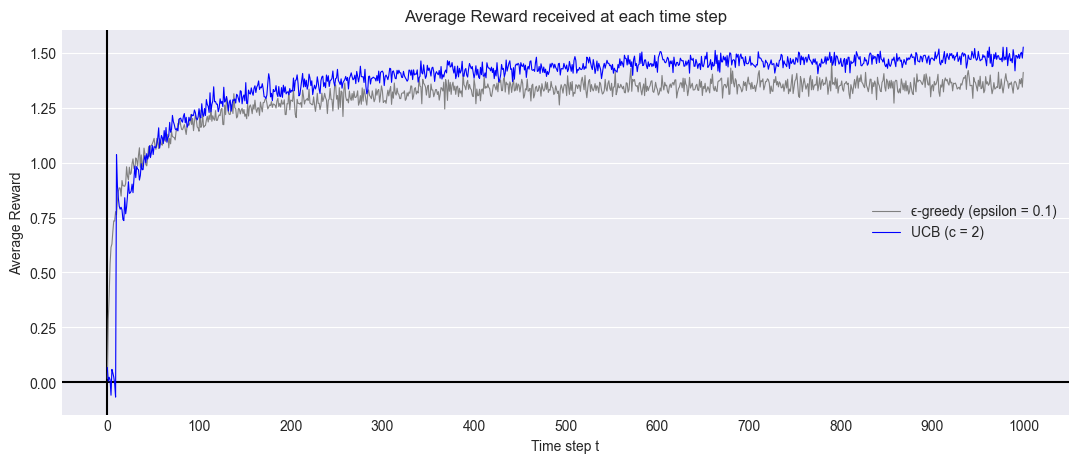

In [19]:
plots = [
    [average_reward[:, 0], dict(linewidth=0.8, alpha=1.0, color="grey", label="ϵ-greedy (epsilon = 0.1)")],
    [average_reward[:, 1], dict(linewidth=0.8, alpha=1.0, color="blue", label="UCB (c = 2)")]
]

xticks = np.arange(0, T+1, 100)
yticks = np.arange(0, 1.65, 0.25)

plot_episodes(plots, (xticks, yticks), ylabel="Average Reward", title="Average Reward received at each time step")

## **Question: 6**

Read Section 2.8 of *Introduction to Reinforcement Learning by Sutton and Barto*. Generate Figure 2.5 (Average over 2000 trials to remove noise).

In [20]:
N: int = 2000
T: int = 1000
k: int = 10

_, optimal_action = parallel_gradient_episodes(N, T, k, alpha=[0.1, 0.4], baseline=[True, False])

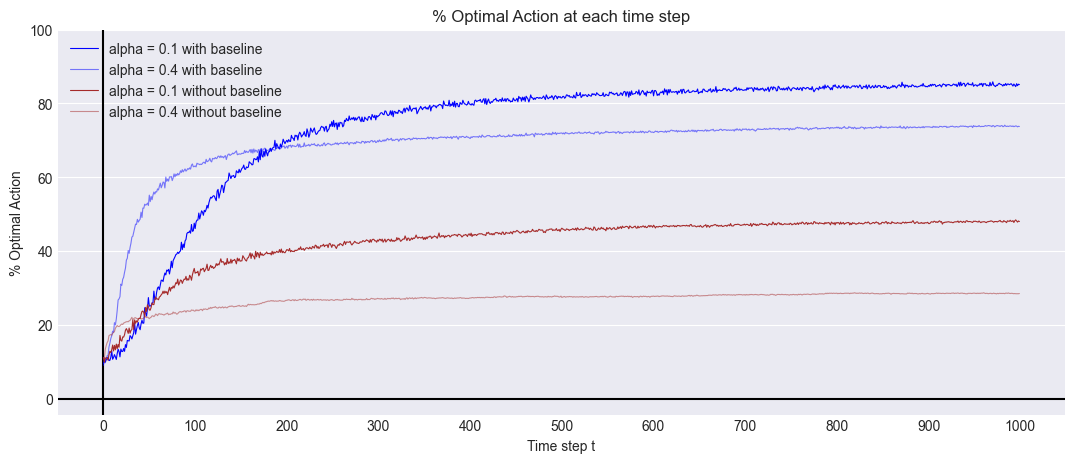

In [21]:
plots = [
    [optimal_action[:, 0, 0], dict(linewidth=0.8, alpha=1.0, color="blue", label="alpha = 0.1 with baseline")],
    [optimal_action[:, 0, 1], dict(linewidth=0.8, alpha=0.5, color="blue", label="alpha = 0.4 with baseline")],
    [optimal_action[:, 1, 0], dict(linewidth=0.8, alpha=1.0, color="brown", label="alpha = 0.1 without baseline")],
    [optimal_action[:, 1, 1], dict(linewidth=0.8, alpha=0.5, color="brown", label="alpha = 0.4 without baseline")]
]

xticks = np.arange(0, T+1, 100)
yticks = np.arange(0, 101, 20)

plot_episodes(plots, (xticks, yticks), ylabel=r"% Optimal Action", title=r"% Optimal Action at each time step")